### Installation des dépendances

In [ ]:
%pip install numpy
%pip install opencv-python
%pip install -U matplotlib
%pip install -U scikit-image
import numpy as np
import cv2 as cv
import math
import matplotlib.pyplot as py
from numpy import linalg as LA
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import os
import time

# Transformée de KL

### Lecture des fichiers images

In [87]:
def plotImage(image, type):
    figure = py.figure(figsize = (10,10))
    imageout = np.clip(image,0,255)
    imageout= imageout.astype(type)
    py.imshow(imageout, cmap='gray')
    py.show()

qualité de compression RGB : pour l'image kodim01.png [(0.16992708644021964, 9.2138681406136)]
qualité de compression YUV : pour l'image kodim01.png [(0.2209073113265814, 14.694233066406067)]


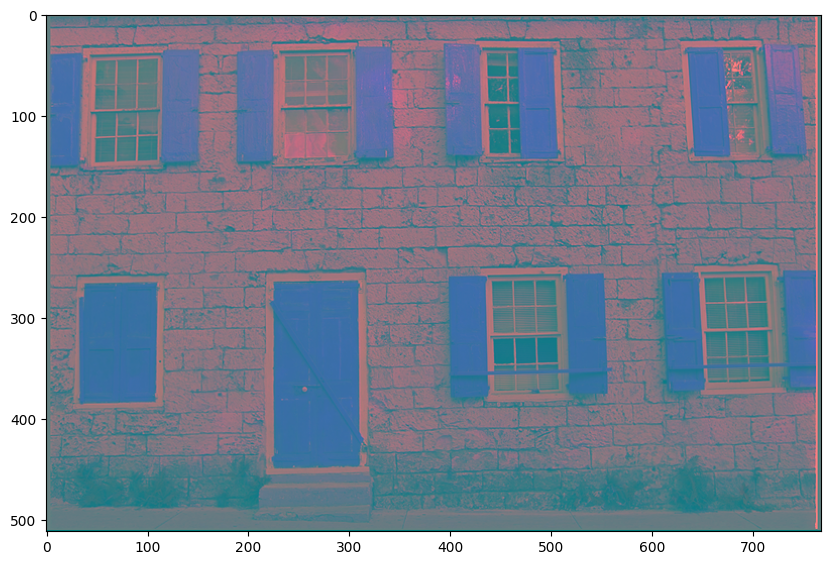

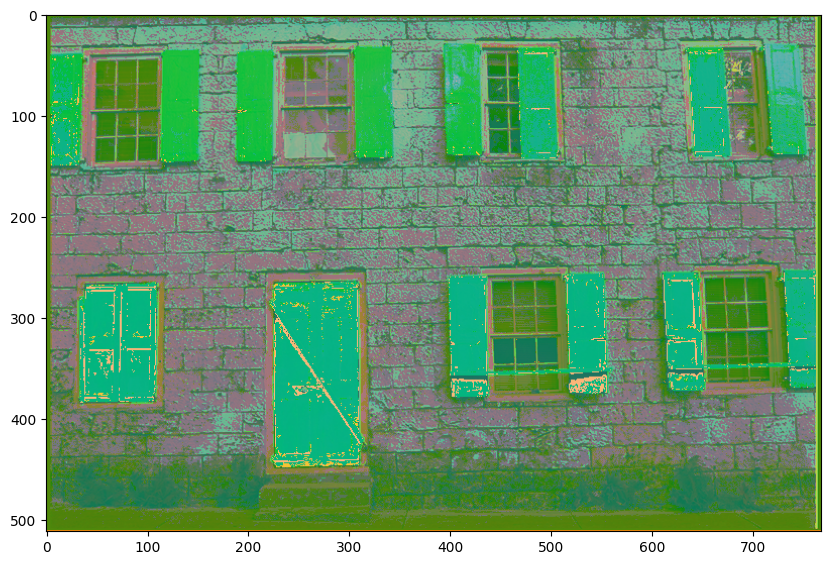

In [203]:

# Read image
dataPath = "/data/"
currDirectory = os.getcwd()
fileList = os.listdir(currDirectory + dataPath)
quantificateur = [[8,8,8], [8,8,4], [8,8,0], [8,4,0]]
qualiteCompressionRGB = []
qualiteCompressionYUV = []

for file in fileList:
    imagePath = currDirectory + dataPath + file
    # img = py.imread(imagePath)
    img = cv.imread(imagePath)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    if img is not None:
        YUVimage = cv.cvtColor(img, cv.COLOR_RGB2YUV)
        for q in quantificateur:
            imageKLTransforme = compression(img, q)
            imageYUVKLTransforme = compression(YUVimage, q)
            qualiteCompressionRGB.append(qualiteCompression(img, imageKLTransforme))
            qualiteCompressionYUV.append(qualiteCompression(YUVimage, imageYUVKLTransforme))
            break
            
        print("qualité de compression RGB : pour l'image " + file, qualiteCompressionRGB)
        qualiteCompressionRGB = []
        print("qualité de compression YUV : pour l'image " + file, qualiteCompressionYUV)
        qualiteCompressionYUV = []
        plotImage(YUVimage, 'uint8')
        plotImage(imageYUVKLTransforme, 'uint8')
        break
    
   

## Question 2
### Implémentation de la transformée de KL 
### Quantification et recomposition de l'image

In [197]:
def compression(image, quantificateur: list):
    # Calcul de la moyenne
    sommeR = 0.0 
    sommeG = 0.0 
    sommeB = 0.0 
    for i in range(len(image)):
        for j in range(len(image[0])):
            sommeR=sommeR+image[i][j][0]
            sommeG=sommeG+image[i][j][1]
            sommeB=sommeB+image[i][j][2]
    nbPixels = len(image)*len(image[0])        
    MoyR= sommeR / nbPixels
    MoyG= sommeG / nbPixels
    MoyB= sommeB / nbPixels
    
    # calcul de la matrice de covariance
    covRGB = np.zeros((3,3), dtype = "double")
    for i in range(len(image)):
        for j in range(len(image[0])):
            vecTemp=[[image[i][j][0] - MoyR], [image[i][j][1]] - MoyG, [image[i][j][2] - MoyB]]
            vecProdTemp = np.dot(vecTemp,np.transpose(vecTemp))
            covRGB = np.add(covRGB,vecProdTemp)
    covRGB = covRGB / nbPixels  
    
    # Calcul des valeurs propres et vecteurs propres
    eigval, eigvec = LA.eig(covRGB)
    eigvec = np.transpose(eigvec)
    
    imageKL = np.copy(image)

    vecMoy = [[MoyR], [MoyG], [MoyB]]

    for i in range(len(image)):
        for j in range(len(image[0])):
            vecTemp = [[image[i][j][0]], [image[i][j][1]], [image[i][j][2]]]
            # a=Mb
            imageKL[i][j][:] = np.reshape(np.dot(eigvec, np.subtract(vecTemp, vecMoy)), (3))

    # Quantification
    imageKLQuantifie = quantize_image(imageKL, quantificateur)
    
    # convertir image KL quantifiée en image RGB
    imageReconvertie = np.copy(imageKLQuantifie)
    # for i in range(len(imageKLQuantifie)):
    #     for j in range(len(imageKLQuantifie[0])):
    #         vecTemp = np.reshape(imageKLQuantifie[i][j], (3, 1))
    #         # Annuler la transformation KL
    #         imageReconvertie[i][j][:] = np.add(np.dot(np.linalg.inv(eigvec), vecTemp), vecMoy).flatten()
    inv_eigvec = np.linalg.inv(eigvec)
    for i in range(len(imageKLQuantifie)):
        for j in range(len(imageKLQuantifie[0])):
            vecTemp = imageKLQuantifie[i, j].reshape(-1, 1)
            imageReconvertie[i, j] = np.dot(inv_eigvec, vecTemp).reshape(3) + np.array(vecMoy).reshape(3) 
                
    
    return imageReconvertie  

In [192]:
def qualiteCompression(imageOriginale, imageCompressee):
    psnr = peak_signal_noise_ratio(imageOriginale, imageCompressee)
    ssim = structural_similarity(imageOriginale, imageCompressee,  win_size=3, data_range=img.max() - img.min())
    return ssim, psnr

In [191]:
def quantize_channel(channel, num_bits):
    num_levels = 2 ** num_bits

    quantization_interval = 256 / num_levels

    quantized_channel = np.round(channel / quantization_interval) * quantization_interval

    quantized_channel = np.clip(quantized_channel, 0, 255)

    return quantized_channel.astype(np.uint8)

def quantize_image(image, num_bits):
    r_channel, g_channel, b_channel = image[:,:,0], image[:,:,1], image[:,:,2]

    quantized_r = quantize_channel(r_channel, num_bits[0])
    quantized_g = quantize_channel(g_channel, num_bits[1])
    quantized_b = quantize_channel(b_channel, num_bits[2])

    quantized_image = np.stack((quantized_r, quantized_g, quantized_b), axis=-1)

    return quantized_image